In [1]:
using Plots,LaTeXStrings
default(markersize=3,linewidth=1.5)
using LinearAlgebra,DifferentialEquations
include("FNC.jl");

# Example 12.1.1

We solve the advection equation on a domain with periodic end conditions. Our approach is the method of lines.

In [2]:
x,Dx,Dxx = FNC.diffper(300,[-4,4])
f = (u,c,t) -> -c*(Dx*u);

The following initial condition isn't mathematically periodic, but the deviation is less than machine precision. We specify RK4 as the solver.  

In [3]:
u_init = @. 1 + exp(-3*x^2)
IVP = ODEProblem(f,u_init,(0.,3.),2.)
sol = solve(IVP,RK4());

An animation shows the solution nicely. The bump moves with speed 2 to the right, reentering on the left as it exits to the right because of the periodic conditions. 

In [4]:
an = @animate for t = LinRange(0,3,120) 
    plot(x,sol(t),
        xaxis=(L"x"),yaxis=([1,2],L"u(x,t)"),    
        title="Advection equation, t=$(round(t,digits=2))",leg=:none )
end
gif(an,"advection.gif")

┌ Info: Saved animation to 
│   fn = /Users/driscoll/Dropbox/books/fnc-extras/julia/advection.gif
└ @ Plots /Users/driscoll/.julia/packages/Plots/oiirH/src/animation.jl:90


Plots.AnimatedGif("/Users/driscoll/Dropbox/books/fnc-extras/julia/advection.gif")

# Example 12.1.2

We solve for traffic flow using periodic boundary conditions. The following are parameters and a function relevant to defining the problem. 

In [5]:
rho_c = 1080;  rho_m = 380;  q_m = 10000;
Q0prime(rho) = q_m*4*rho_c^2*(rho_c-rho_m)*rho_m*(rho_m-rho)/(rho*(rho_c-2*rho_m) + rho_c*rho_m)^3;

Here we create a discretization on $m=800$ points.

In [6]:
x,Dx,Dxx = FNC.diffper(800,[0,4]);

Next we define the ODE resulting from the method of lines.

In [7]:
ode = (rho,ep,t) -> -Q0prime.(rho).*(Dx*rho) + ep*(Dxx*rho);

Our first initial condition has moderate density with a small bump.

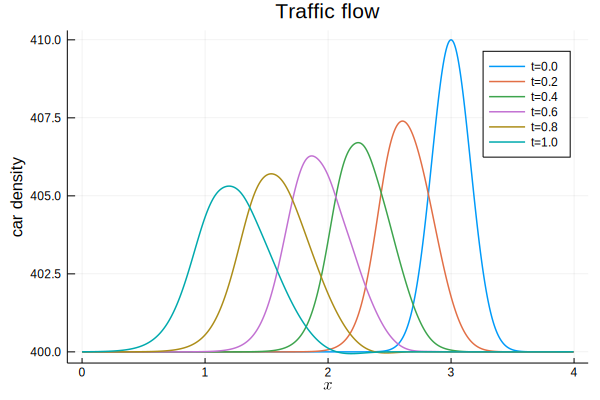

In [8]:
rho_init = @. 400 + 10*exp(-20*(x-3)^2)
IVP = ODEProblem(ode,rho_init,(0.,1.),0.02)
sol = solve(IVP,alg_hints=[:stiff]);

plot(x,[sol(t) for t=0:.2:1],label=["t=$t" for t=0:.2:1],
    xaxis=(L"x"),yaxis=("car density"),title="Traffic flow")     

The bump slowly moves backward on the roadway, spreading out and gradually fading away due to the presence of diffusion.

In [9]:
an = @animate for t = LinRange(0,0.9,91) 
    plot(x,sol(t),
        xaxis=(L"x"),yaxis=([400,410],"density"),    
        title="Traffic flow, t=$(round(t,digits=2))",leg=:none )
end
gif(an,"traffic1.gif")

┌ Info: Saved animation to 
│   fn = /Users/driscoll/Dropbox/books/fnc-extras/julia/traffic1.gif
└ @ Plots /Users/driscoll/.julia/packages/Plots/oiirH/src/animation.jl:90


Plots.AnimatedGif("/Users/driscoll/Dropbox/books/fnc-extras/julia/traffic1.gif")

Now we use an initial condition with a larger bump. 

In [10]:
rho_init = @. 400 + 80*exp(-16*(x-3)^2)
IVP = ODEProblem(ode,rho_init,(0.,0.5),0.02)
sol = solve(IVP,alg_hints=[:stiff]);

In [11]:
an = @animate for t = LinRange(0,0.5,101) 
    plot(x,sol(t),
        xaxis=(L"x"),yaxis=([400,480],"density"),    
        title="A traffic jam, t=$(round(t,digits=2))",leg=:none )
end
gif(an,"traffic2.gif")

┌ Info: Saved animation to 
│   fn = /Users/driscoll/Dropbox/books/fnc-extras/julia/traffic2.gif
└ @ Plots /Users/driscoll/.julia/packages/Plots/oiirH/src/animation.jl:90


Plots.AnimatedGif("/Users/driscoll/Dropbox/books/fnc-extras/julia/traffic2.gif")

In this case the density bump travels backward along the road. It also steepens on the side facing the incoming traffic and decreases much more slowly on the other side. A motorist would experience this as an abrupt increase in density, followed by a much more gradual decrease in density and resulting gradual increase in speed. (You also see some transient, high-frequency oscillations. These are caused by instabilities, as we discuss in simpler situations later in this chapter.)

# Example 12.2.1

We set up a test problem with velocity $c=2$ and periodic end conditions. 

In [12]:
x,Dx = FNC.diffper(400,[0 1])
uinit = @. exp(-80*(x-0.5)^2);

For this problem we use `RK4`, an explicit method. 

In [13]:
ode = (u,c,t) -> -c*(Dx*u);
IVP = ODEProblem(ode,uinit,(0.,2.),2.)
sol = solve(IVP,RK4());

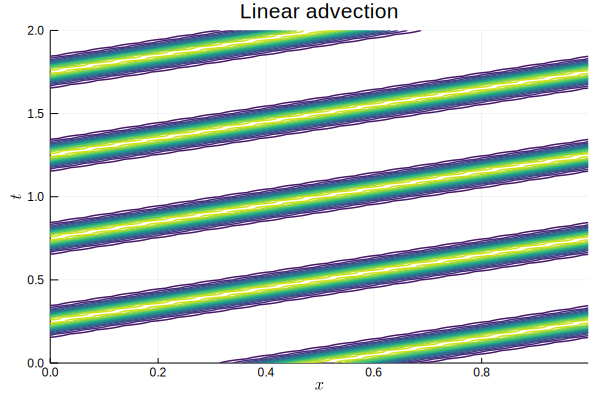

In [14]:
t = 2*(0:80)/80
u = hcat([sol(t) for t in t]...)
contour(x,t,u',color=:viridis,
    xaxis=(L"x"),yaxis=(L"t"),title="Linear advection",leg=:none)

You can see the hump traveling rightward at constant speed, traversing the domain once for each integer multiple of $t=1/2$. We note the average time step that was chosen:

In [15]:
avgtau1 = sum(diff(sol.t))/(length(sol.t)-1)

0.0035460992907801418

We cut $h$ by a factor of two and solve again.

In [16]:
x,Dx = FNC.diffper(800,[0 1])
uinit = @. exp(-80*(x-0.5)^2);
IVP = ODEProblem(ode,uinit,(0.,2.),2.)
sol = solve(IVP,RK4());

The CFL condition suggests that the time step should be cut by a factor of two also.

In [17]:
avgtau2 = sum(diff(sol.t))/(length(sol.t)-1)
@show ratio = avgtau1 / avgtau2

ratio = avgtau1 / avgtau2 = 1.9982269503546097


1.9982269503546097

# Example 12.2.2

We set up advection over $[0,1]$ with velocity $c=-1$. This puts the right-side boundary in the upwind direction.

In [18]:
n = 100
x,Dx = FNC.diffmat2(n,[0 1])
uinit = @. exp(-80*(x-0.5)^2);

First we try imposing $u=0$ at the right boundary, by appending that value to the end of the vector before multiplying by the differentiation matrix.

In [19]:
trunc = u -> u[1:n];  extend = v -> [v;0];
ode = (v,c,t) -> -c*trunc(Dx*extend(v));
IVP = ODEProblem(ode,uinit[1:n],(0.,1.),-1)
sol = solve(IVP,RK4());

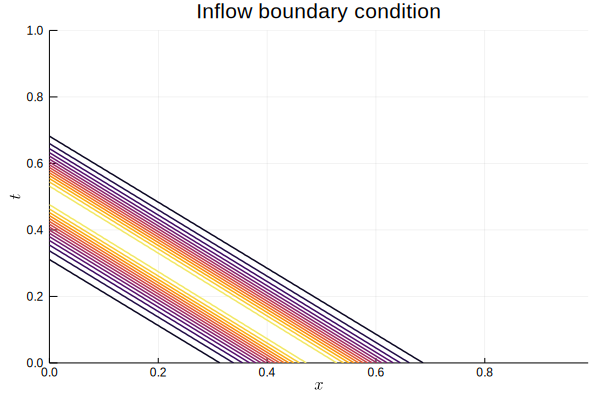

In [20]:
plot(x[1:n],sol.t,sol[:,:]',
    xlabel=L"x",ylabel=L"t",title="Inflow boundary condition",leg=:none)

The data from the initial condition propagates out of the left edge. Because only zero is coming in from the upwind direction, the solution remains zero thereafter.

Now we try $u=0$ imposed at the left boundary. 

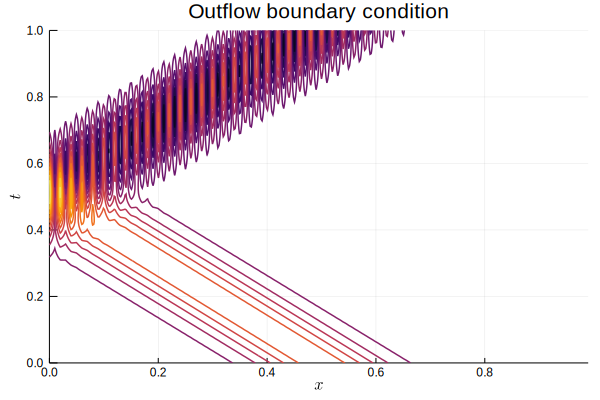

In [21]:
trunc = u -> u[2:n+1];  extend = v -> [0;v];
sol = solve(IVP,RK4());
plot(x[1:n],sol.t,sol[:,:]',
    xlabel=L"x",ylabel=L"t",title="Outflow boundary condition",leg=:none)

Everything seems OK until the data begins to interact with the inappropriate boundary condition. The resulting "reflection" is entirely wrong for advection from right to left. 

# Example 12.3.1

For $c=1$ we get the eigenvalues:

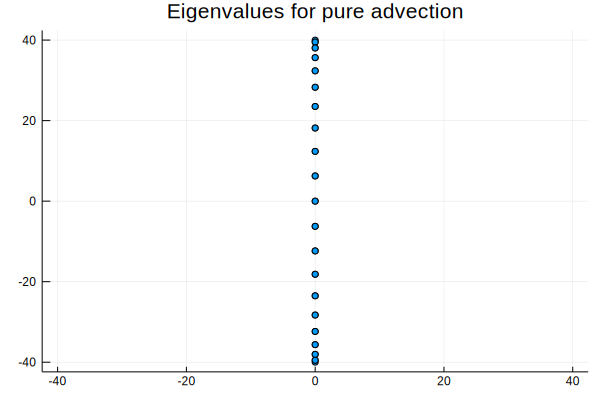

In [22]:
x,Dx = FNC.diffper(40,[0,1])
lambda = eigvals(Dx);

scatter(real(lambda),imag(lambda),xlim=[-40,40],ylim=[-40,40],
    title="Eigenvalues for pure advection",leg=:none)     

Let's choose a time step of $\tau=0.1$ and compare to the stability regions of the Euler and backward Euler time steppers.

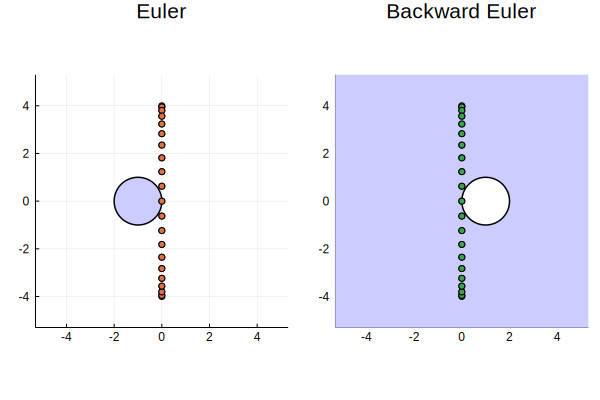

In [23]:
zc = @.exp(1im*2pi*(0:360)/360);    # points on |z|=1

z = zc .- 1;                        # shift left by 1
plot(Shape(real(z),imag(z)),color=RGB(.8,.8,1),layout=(1,2),subplot=1)
scatter!(real(0.1*lambda),imag(0.1*lambda),subplot=1,
    xlim=[-5,5],ylim=[-5,5],aspect_ratio=1,title="Euler",leg=:none)

z = zc .+ 1;                        # shift right by 1
plot!(Shape([-6,6,6,-6],[-6,-6,6,6]),color=RGB(.8,.8,1),subplot=2)
plot!(Shape(real(z),imag(z)),color=:white,subplot=2)
scatter!(real(0.1*lambda),imag(0.1*lambda),subplot=2,
    xlim=[-5,5],ylim=[-5,5],aspect_ratio=1,title="Backward Euler",leg=:none)

In the Euler case it's clear that *no* real value of $\tau>0$ is going to make all (or even any) of the $\tau\lambda_j$ fit within the stability region. Hence Euler will never produce bounded solutions to this discretization of the advection equation. The A-stable backward Euler time stepping tells the exact opposite story; it will be absolutely stable regardless of $\tau$.

# Example 12.3.2

The eigenvalues of advection--diffusion are near-imaginary for $\epsilon\approx 0$ and more negative-real for increasing values of $\epsilon$.

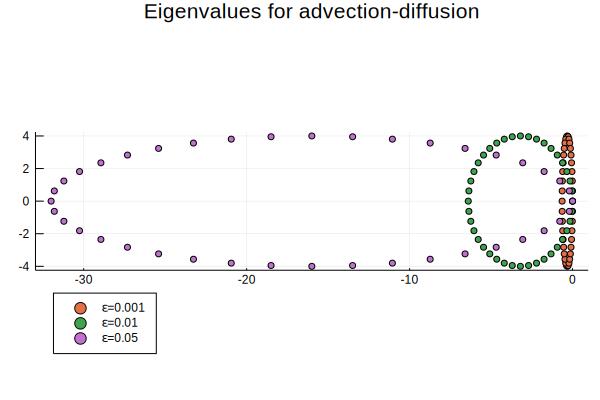

In [24]:
plot([],[],label="",leg=:left,aspect_ratio=1)
x,Dx,Dxx = FNC.diffper(40,[0,1]);
tau = 0.1
for ep = [0.001 0.01 0.05]
  lambda = eigvals(-Dx + ep*Dxx)
  scatter!(real(tau*lambda),imag(tau*lambda),label="\\epsilon=$ep")
end
title!("Eigenvalues for advection-diffusion")     

# Example 12.3.3

Deleting the first row and column places all the eigenvalues of the discretization into the left half of the complex plane. 

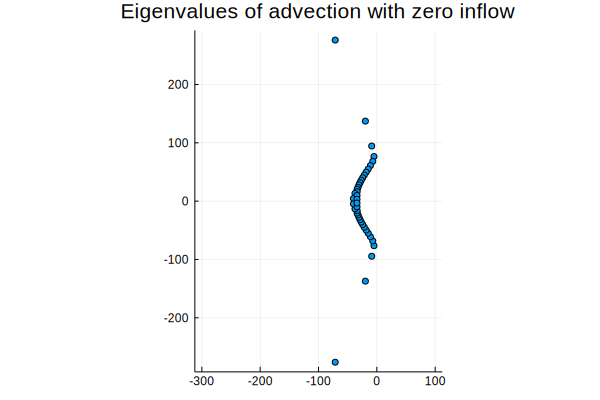

In [25]:
x,Dx,Dxx = FNC.diffcheb(40,[0,1]);
A = -Dx[2:end,2:end];    # leave out first row and column

lambda = eigvals(A)
scatter(real(lambda),imag(lambda),
    xlim=[-300,100],title="Eigenvalues of advection with zero inflow",leg=:none,aspect_ratio=1) 

Note that the rightmost eigenvalues have real part at most

In [26]:
maximum( real(lambda) )

-4.931967035822995

Consequently all solutions decay exponentially to zero as $t\to\infty$. This matches the intuition of a flow with nothing at the inlet: eventually everything flows out of the domain. 

# Example 12.4.1

We solve the wave equation (in Maxwell form) for speed $c=2$, with homogeneous Dirichlet conditions on the first variable. 

In [27]:
m = 200
x,Dx = FNC.diffmat2(m,[-1,1]);

The boundary values of $u$ are given to be zero, so they are not unknowns in the ODEs we solve. Instead they are added or removed as necessary. 

In [28]:
trunc = u -> u[2:m];
extend = v -> [0;v;0];

The following function computes the time derivative of the system at interior points.

In [29]:
dwdt = function(w,c,t)
    u = extend(w[1:m-1])
    z = w[m:2*m]
    dudt = Dx*z
    dzdt = c^2*(Dx*u)
    return [ trunc(dudt); dzdt ]
end;

Our initial condition is a single hump for $u$.

In [30]:
u_init = @.exp(-100*(x)^2)
z_init = -u_init
w_init = [ trunc(u_init); z_init ];  

Because the wave equation is hyperbolic, we can use a nonstiff explicit solver.

In [31]:
IVP = ODEProblem(dwdt,w_init,(0.,2.),2)
sol = solve(IVP,RK4());

We extract the original $u$ and $z$ variables from the results,  adding in the zeros at the boundaries for $u$.

In [32]:
n = length(sol.t)-1
U = [ zeros(1,n+1); sol[1:m-1,:]; zeros(1,n+1) ];
Z = sol[m:2*m,:];

We plot the results for the original $u$ variable. 

In [33]:
an = @animate for (i,t) = enumerate(sol.t) 
    plot(x,U[:,i],layout=(1,2),subplot=1,
        xaxis=(L"x"),yaxis=([-1,1],L"u(x,t)"),    
        title="Wave equation, t=$(round(t,digits=3))",leg=:none )
    plot!(x,sol.t,U',subplot=2,xlabel=L"x",ylabel=L"t",title="Space-time view",leg=:none)
end
gif(an,"wave.gif")

┌ Info: Saved animation to 
│   fn = /Users/driscoll/Dropbox/books/fnc-extras/julia/wave.gif
└ @ Plots /Users/driscoll/.julia/packages/Plots/oiirH/src/animation.jl:90


Plots.AnimatedGif("/Users/driscoll/Dropbox/books/fnc-extras/julia/wave.gif")

The original hump breaks into two pieces of different amplitudes. Each travels with speed $c=2$, and they pass through one another without interference. When a hump encounters a boundary, it is perfectly reflected, but with inverted shape. At time $t=2$ the exact solution looks just like the initial condition.

# Example 12.4.2

We now use a wave speed that is discontinuous at $x=0$. 

In [34]:
m = 120
x,Dx = FNC.diffcheb(m,[-1,1]);
c = @. 1 + (sign(x)+1)/2
trunc = u -> u[2:m];
extend = v -> [0;v;0];

This function computes the time derivative of the method-of-lines system.

In [35]:
dwdt = function(w,c,t)
    u = extend(w[1:m-1])
    z = w[m:2*m]
    dudt = Dx*z
    dzdt = c.^2 .* (Dx*u)
    return [ trunc(dudt); dzdt ]
end;

We set the initial conditions and solve using |ode45|.

In [36]:
u_init = @.exp(-100*(x+0.5)^2);
z_init = -u_init;
w_init = [ trunc(u_init); z_init ];    
IVP = ODEProblem(dwdt,w_init,(0.,5.),c)
sol = solve(IVP,RK4());

At each time in the following animation, we evaluate the discrete solution for $u$ and then extend it to the boundaries using the boundary conditions. 

In [37]:
an = @animate for t = LinRange(0,5,200)
    plot(x,extend(sol(t,idxs=1:m-1)),
        xaxis=(L"x"),yaxis=([-1,1],L"u(x,t)"),    
        title="Wave equation, variable speed",label="t=$(round(t,digits=2))" )
end
gif(an,"wavereflect.gif")

┌ Info: Saved animation to 
│   fn = /Users/driscoll/Dropbox/books/fnc-extras/julia/wavereflect.gif
└ @ Plots /Users/driscoll/.julia/packages/Plots/oiirH/src/animation.jl:90


Plots.AnimatedGif("/Users/driscoll/Dropbox/books/fnc-extras/julia/wavereflect.gif")

Each pass through the interface at $x=0$ generates a reflected and transmitted wave. By conservation of energy, these are both smaller in amplitude than the incoming bump. 